In [108]:
import os
import tensorflow as tf
import numpy as np
import itertools

Init Plugin
Init Graph Optimizer
Init Kernel


In [109]:
import os
import json
from pprint import pprint
from copy import deepcopy

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [172]:
biorxiv_dir = '/Users/swathipathaikara/Desktop/DCSI/Optimization/DataSet/Documents3/'
filenames = os.listdir(biorxiv_dir)
print("Number of articles retrieved from biorxiv:", len(filenames))

Number of articles retrieved from biorxiv: 3000


In [173]:
all_files = []

for filename in filenames:
    filename = biorxiv_dir + filename
    file = json.load(open(filename, 'rb'))
    all_files.append(file)

In [174]:
len(all_files)

3000

In [175]:
file = all_files[0]
print("Dictionary keys:", file.keys())

Dictionary keys: dict_keys(['paper_id', 'metadata', 'abstract', 'body_text', 'bib_entries', 'ref_entries', 'back_matter'])


In [176]:
pprint(file['abstract'])

[{'cite_spans': [],
  'ref_spans': [],
  'section': 'Abstract',
  'text': 'Comparative evaluations of national survey data can improve future '
          'survey design and sampling strategies thereby enhancing our ability '
          'to detect important population level trends. This paper presents '
          'differences in past year estimates of alcohol, cigarette, '
          'marijuana, and non-medical painkiller use prevalence by age, sex, '
          'and race/ ethnicity between the 2012 National Survey on Drug Use '
          'and Health (NSDUH) and the National Epidemiologic Survey on Alcohol '
          'and Related Conditions (NESARC-III) administered in 2012-2013. In '
          'general, estimates were higher for the NSDUH survey, but patterns '
          'of substance use prevalence were similar across race/ethnicity, '
          'age, and sex. Results show most significant differences in '
          'estimates, across substances, age groups, and sex were greatest '
    

In [177]:
print("body_text type:", type(file['body_text']))
print("body_text length:", len(file['body_text']))
print("body_text keys:", file['body_text'][0].keys())

body_text type: <class 'list'>
body_text length: 20
body_text keys: dict_keys(['text', 'cite_spans', 'ref_spans', 'section'])


In [178]:
print("body_text content:")
pprint(file['body_text'][:2], depth=3)

body_text content:
[{'cite_spans': [],
  'ref_spans': [],
  'section': '',
  'text': 'Disorder and Associated Disabilities Interview Schedule 5 '
          '(AUDADIS-5) modules. Following the interview, participants who '
          'consented provided a saliva sample.'},
 {'cite_spans': [{...},
                 {...},
                 {...},
                 {...},
                 {...},
                 {...},
                 {...},
                 {...},
                 {...},
                 {...},
                 {...},
                 {...},
                 {...}],
  'ref_spans': [],
  'section': '',
  'text': 'The NSDUH is sponsored by the Center for Behavioral Health '
          'Statistics and Quality office within the Substance Abuse and Mental '
          'Health Services Administration. PSUs comprised approximately '
          '500,000 area segments (groups of adjacent census blocks). The first '
          'stage of sampling involved selection of eight such segments 

In [179]:
texts = [(di['section'], di['text']) for di in file['body_text']]
texts_di = {di['section']: "" for di in file['body_text']}
for section, text in texts:
    texts_di[section] += text

pprint(list(texts_di.keys()))

['',
 'Sample',
 'Measures',
 'Analysis',
 'Results',
 'Past Year Alcohol Use Prevalence by Race/Ethnicity, Sex, and Age',
 'Past Year Cigarette Use Prevalence by Race/Ethnicity, Sex, and Age',
 'Past Year Marijuana Use Prevalence by Race/Ethnicity, Sex, and Age',
 'Past Year Non-medical Painkiller Use Prevalence by Race/Ethnicity, Sex, and '
 'Age',
 'Discussion',
 'Limitations']


In [180]:
body = ""

for section, text in texts_di.items():
    body += section
    body += "\n\n"
    body += text
    body += "\n\n"

print(body[:3000])



Disorder and Associated Disabilities Interview Schedule 5 (AUDADIS-5) modules. Following the interview, participants who consented provided a saliva sample.The NSDUH is sponsored by the Center for Behavioral Health Statistics and Quality office within the Substance Abuse and Mental Health Services Administration. PSUs comprised approximately 500,000 area segments (groups of adjacent census blocks). The first stage of sampling involved selection of eight such segments from each of 900 geographic 'field interviewer' (FI) regions. The frames for the second stage of sampling consist of lists of all dwelling units within segment boundaries. Samples of dwelling units were selected from these lists. Individuals were selected from rosters obtained by dwelling unit visits. Approximately 700 field interviewers visited homes and collected data from participants. All NSDUH surveys conducted after 1999 utilized a Computer Assisted Interview (CAI) methodology comprising of a core and supplement st

In [181]:
def format_name(author):
    middle_name = " ".join(author['middle'])
    
    if author['middle']:
        return " ".join([author['first'], middle_name, author['last']])
    else:
        return " ".join([author['first'], author['last']])


def format_affiliation(affiliation):
    text = []
    location = affiliation.get('location')
    if location:
        text.extend(list(affiliation['location'].values()))
    
    institution = affiliation.get('institution')
    if institution:
        text = [institution] + text
    return ", ".join(text)

def format_authors(authors, with_affiliation=False):
    name_ls = []
    
    for author in authors:
        name = format_name(author)
        if with_affiliation:
            affiliation = format_affiliation(author['affiliation'])
            if affiliation:
                name_ls.append(f"{name} ({affiliation})")
            else:
                name_ls.append(name)
        else:
            name_ls.append(name)
    
    return ", ".join(name_ls)

def format_body(body_text):
    texts = [(di['section'], di['text']) for di in body_text]
    texts_di = {di['section']: "" for di in body_text}
    
    for section, text in texts:
        texts_di[section] += text

    body = ""

    for section, text in texts_di.items():
        body += section
        body += "\n\n"
        body += text
        body += "\n\n"
    
    return body

def format_bib(bibs):
    if type(bibs) == dict:
        bibs = list(bibs.values())
    bibs = deepcopy(bibs)
    formatted = []
    
    for bib in bibs:
        bib['authors'] = format_authors(
            bib['authors'], 
            with_affiliation=False
        )
        formatted_ls = [str(bib[k]) for k in ['title', 'authors', 'venue', 'year']]
        formatted.append(", ".join(formatted_ls))

    return "; ".join(formatted)

In [182]:
def load_files(dirname):
    filenames = os.listdir(dirname)
    raw_files = []

    for filename in tqdm(filenames):
        filename = dirname + filename
        file = json.load(open(filename, 'rb'))
        raw_files.append(file)
    
    return raw_files

def generate_clean_df(all_files):
    cleaned_files = []
    
    for file in tqdm(all_files):
        features = [
            file['paper_id'],
            file['metadata']['title'],
            format_authors(file['metadata']['authors']),
            format_authors(file['metadata']['authors'], 
                           with_affiliation=True),
            format_body(file['abstract']),
            format_body(file['body_text']),
            format_bib(file['bib_entries']),
            file['metadata']['authors'],
            file['bib_entries']
        ]

        cleaned_files.append(features)

    col_names = ['paper_id', 'title', 'authors',
                 'affiliations', 'abstract', 'text', 
                 'bibliography','raw_authors','raw_bibliography']

    clean_df = pd.DataFrame(cleaned_files, columns=col_names)
    clean_df.head()
    
    return clean_df

In [183]:
print(format_body(file['body_text'])[:3000])



Disorder and Associated Disabilities Interview Schedule 5 (AUDADIS-5) modules. Following the interview, participants who consented provided a saliva sample.The NSDUH is sponsored by the Center for Behavioral Health Statistics and Quality office within the Substance Abuse and Mental Health Services Administration. PSUs comprised approximately 500,000 area segments (groups of adjacent census blocks). The first stage of sampling involved selection of eight such segments from each of 900 geographic 'field interviewer' (FI) regions. The frames for the second stage of sampling consist of lists of all dwelling units within segment boundaries. Samples of dwelling units were selected from these lists. Individuals were selected from rosters obtained by dwelling unit visits. Approximately 700 field interviewers visited homes and collected data from participants. All NSDUH surveys conducted after 1999 utilized a Computer Assisted Interview (CAI) methodology comprising of a core and supplement st

In [184]:
print(all_files[0]['metadata'].keys())

dict_keys(['title', 'authors'])


In [185]:
print(all_files[0]['metadata']['title'])

Comparison of Past Year Substance Use Estimates by Age, Sex, and Race/Ethnicity Between Two Representative Samples of the U.S. Adult Population


In [186]:
authors = all_files[0]['metadata']['authors']
pprint(authors[:3])

[{'affiliation': {'institution': 'University of Nevada',
                  'laboratory': '',
                  'location': {'addrLine': 'Las Vegas, 4505 S. Maryland Pkwy, '
                                           'Las Vegas',
                               'country': 'USA',
                               'postCode': '89154',
                               'region': 'NV'}},
  'email': 'timothy.grigsby@unlv.edu',
  'first': 'Timothy',
  'last': 'Grigsby',
  'middle': ['J'],
  'suffix': ''},
 {'affiliation': {'institution': 'Texas State University',
                  'laboratory': '',
                  'location': {'addrLine': '601 University Dr',
                               'country': 'USA',
                               'postCode': '78666',
                               'region': 'TX',
                               'settlement': 'San Marcos'}},
  'email': '',
  'first': 'Krista',
  'last': 'Howard',
  'middle': [],
  'suffix': ''},
 {'affiliation': {'institution': 'One UTSA Cir

In [187]:
for author in authors:
    print("Name:", format_name(author))
    print("Affiliation:", format_affiliation(author['affiliation']))
    print()

Name: Timothy J Grigsby
Affiliation: University of Nevada, Las Vegas, 4505 S. Maryland Pkwy, Las Vegas, 89154, NV, USA

Name: Krista Howard
Affiliation: Texas State University, 601 University Dr, 78666, San Marcos, TX, USA

Name: Jeffrey T Howard
Affiliation: One UTSA Cir, 78249, San Antonio, TX, USA



In [188]:
pprint(all_files[1]['metadata'], depth=4)

{'authors': [], 'title': ''}


In [189]:
authors = all_files[1]['metadata']['authors']
print("Formatting without affiliation:")
print(format_authors(authors, with_affiliation=False))
print("\nFormatting with affiliation:")
print(format_authors(authors, with_affiliation=True))

Formatting without affiliation:


Formatting with affiliation:



In [190]:
bibs = list(file['bib_entries'].values())
pprint(bibs[:2], depth=4)

[{'authors': [{'first': 'D', 'last': 'Albright', 'middle': [...], 'suffix': ''},
              {'first': 'L', 'last': 'Holmes', 'middle': [], 'suffix': ''},
              {'first': 'M', 'last': 'Lawson', 'middle': [], 'suffix': ''},
              {'first': 'J', 'last': 'Mcdaniel', 'middle': [], 'suffix': ''},
              {'first': 'K', 'last': 'Laha-Walsh', 'middle': [], 'suffix': ''},
              {'first': 'S', 'last': 'Mcintosh', 'middle': [], 'suffix': ''}],
  'issn': '',
  'other_ids': {},
  'pages': '1--13',
  'ref_id': 'b0',
  'title': 'Veteran-nonveteran differences in alcohol and drug misuse by '
           'tobacco use status in Alabama SBIRT',
  'venue': 'Journal of Social Work Practice int he Addictions',
  'volume': '20',
  'year': 2019},
 {'authors': [{'first': 'K', 'last': 'Berry', 'middle': [...], 'suffix': ''},
              {'first': 'J',
               'last': 'Fetterman',
               'middle': [...],
               'suffix': ''},
              {'first': 'E', '

In [191]:
format_authors(bibs[1]['authors'], with_affiliation=False)

'K M Berry, J L Fetterman, E J Benjamin, A Bhatnagar, J L Barrington-Trimis, A M Leventhal, A Stokes'

In [192]:
bib_formatted = format_bib(bibs[:5])
print(bib_formatted)

Veteran-nonveteran differences in alcohol and drug misuse by tobacco use status in Alabama SBIRT, D L Albright, L Holmes, M Lawson, J Mcdaniel, K Laha-Walsh, S Mcintosh, Journal of Social Work Practice int he Addictions, 2019; Association of electronic cigarette use with subsequent initiation of tobacco cigarettes in US youths, K M Berry, J L Fetterman, E J Benjamin, A Bhatnagar, J L Barrington-Trimis, A M Leventhal, A Stokes, JAMA Network Open, 2019; Prevalence of cardiovascular risk factors in the population of Vitória according to data from VIGITEL and the National health interview survey of 2013, M V Borgo, E B Pimentel, M P Baldo, J B D Souza, D C Malta, J G Mill, , 2019; Marijuana use from adolescence to adulthood: Developmental trajectories and their outcomes, J S Brook, C Zhang, C G Leukefeld, D W Brook, Social Psychiatry and Psychiatric Epidemiology, 2016; Rising morbidity and mortality in midlife among white non-Hispanic Americans in the 21st century, A Case, A Deaton, Procee

In [193]:
cleaned_files = []

for file in tqdm(all_files):
    features = [
        file['paper_id'],
        file['metadata']['title'],
        format_authors(file['metadata']['authors']),
        format_authors(file['metadata']['authors'], 
                       with_affiliation=True),
        format_body(file['abstract']),
        format_body(file['body_text']),
        format_bib(file['bib_entries']),
        file['metadata']['authors'],
        file['bib_entries']
    ]
    
    cleaned_files.append(features)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [194]:
col_names = [
    'paper_id', 
    'title', 
    'authors',
    'affiliations', 
    'abstract', 
    'text', 
    'bibliography',
    'raw_authors',
    'raw_bibliography'
]

clean_df = pd.DataFrame(cleaned_files, columns=col_names)
clean_df.head()

,paper_id,title,authors,affiliations,abstract,text,bibliography,raw_authors,raw_bibliography
0,d21264a0ff5e40019e30d40f569ea8033fb3103e,Comparison of Past Year Substance Use Estimate...,"Timothy J Grigsby, Krista Howard, Jeffrey T Ho...","Timothy J Grigsby (University of Nevada, Las V...",Abstract\n\nComparative evaluations of nationa...,\n\nDisorder and Associated Disabilities Inter...,Veteran-nonveteran differences in alcohol and ...,"[{'first': 'Timothy', 'middle': ['J'], 'last':...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Veteran..."
1,304a6f893c12b837b18908ead759245d221b2087,,,,Abstract\n\nObjective: To compare\n\n,Introduction\n\nDespite advances in critical c...,Has the mortality of septic shock changed with...,[],"{'BIBREF0': {'ref_id': 'b0', 'title': 'Has the..."
2,a3938d39f4b153cbf361d2846a77ff205cddb8dc,Oligomers of hepatitis A virus (HAV) capsid pr...,"Anshu Nain, Mohit Kumar, Manidipa Banerjee","Anshu Nain, Mohit Kumar, Manidipa Banerjee",Abstract\n\nBackground: The quasi-enveloped pi...,"\n\nHepatitis A Virus (HAV), the causative age...",Enhanced papillomaviruslike particle productio...,"[{'first': 'Anshu', 'middle': [], 'last': 'Nai...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Enhance..."
3,753e17836a2d144c691656b111e4985eeecae427,SARS-COV-2 Omicron variant predicted to exhibi...,"Adam Zemla, Thomas Desautels, Edmond Y Lau, Fa...","Adam Zemla, Thomas Desautels, Edmond Y Lau, Fa...",Abstract\n\nRapid assessment of whether a pand...,Background\n\nThe recently emerged Omicron var...,Modeling structurally variable regions in homo...,"[{'first': 'Adam', 'middle': [], 'last': 'Zeml...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Modelin..."
4,70795243242f5e78ea123784f9e9b5dc19429257,,"Martin J Tobin, Amal Jubran, M D Franco, Hine...","Martin J Tobin, Amal Jubran, M D Franco, Hine...",,\n\nselected in a post hoc manner-a step known...,The respiratory drive: an overlooked tile of C...,"[{'first': 'Martin', 'middle': ['J'], 'last': ...","{'BIBREF0': {'ref_id': 'b0', 'title': 'The res..."


In [195]:
clean_df.to_csv('consolidatedData.csv', index=False)

In [76]:
consolidatedData = pd.read_csv('/Users/swathipathaikara/Desktop/DCSI/Optimization/consolidatedData.csv')

In [77]:
consolidatedData.head(2)

,paper_id,title,authors,affiliations,abstract,text,bibliography,raw_authors,raw_bibliography
0,0a97df6b17b88938b88b59380308cb320d19fa83,Effects of biopsychosocial factors on the asso...,"Olga Megalakaki, Cyrille Kossigan Kokou-Kpolou","Olga Megalakaki, Cyrille Kossigan Kokou-Kpolou",Abstract\n\nPrevious data suggest that lonelin...,"Introduction\n\nOn 24 January 2020, the first ...",Prospective relations between loneliness in di...,"[{'first': 'Olga', 'middle': [], 'last': 'Mega...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Prospec..."
1,0aa4c649e5325587a19af4fd234a308314283ae6,NaN,"Cheng-Wen Lin, Szu-Hao Kung, Jean Jacques, Van...","Cheng-Wen Lin, Szu-Hao Kung, Jean Jacques, Van...","Abstract\n\nCitation: Zhang, F.; He, P.; Rodri...","Introduction\n\nThe ongoing COVID-19 pandemic,...","WHO. Tracking SARS-CoV-2 Variants, , , 2022; G...","[{'first': 'Cheng-Wen', 'middle': [], 'last': ...","{'BIBREF0': {'ref_id': 'b0', 'title': 'WHO. Tr..."


In [78]:
consolidatedData.text[0]

'Introduction\n\nOn 24 January 2020, the first official COVID-19 cases were announced in France. By January 2021, France had become the third most affected European country in terms of COVID-19 cases and deaths. In response to successive outbreaks, the French Government has imposed strict public health measures, including a total national lockdown during the first outbreak, when universities, and nonessential businesses had to close, and sports, religious and cultural events were cancelled. In addition to public health measures, social distancing has become the main policy in terms of public behaviour. Research has shown that even though public health measures like these are necessary to curb the rapid worldwide spread of the virus, they have affected the psychological wellbeing and mental health of large portions of the world\'s populations (Brooks et al., 2020) . Meta-analytic findings have revealed high prevalence rates of severe mental health conditions, including posttraumatic str

In [79]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

stopwords = set(STOPWORDS)
#https://www.kaggle.com/gpreda/cord-19-solution-toolbox

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=30, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=14)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

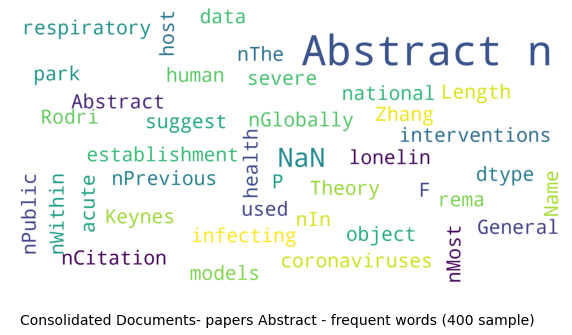

In [80]:
show_wordcloud(consolidatedData['abstract'], title = 'Consolidated Documents- papers Abstract - frequent words (400 sample)')

In [81]:
df = consolidatedData
df = df.abstract.dropna()
data = df.values.tolist()

In [82]:
simsentence = pd.read_csv('/Users/swathipathaikara/Desktop/DCSI/Optimization/simsentence.csv')

In [83]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  

data_words = list(sent_to_words(data))

print(data_words[:1])

NameError: name 'gensim' is not defined

In [74]:
conda install -c conda-forge gensim

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: \ 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
Examining conflict for s3transfer boto3 botocore:  74%|▋| 213/288 [06:56<00:12\ ^C
                                                                               failed

CondaError: KeyboardInterrupt


Note: you may need to restart the kernel to use updated packages.


In [75]:
pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 8.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 1.9 MB/s eta 0:00:00
  Created wheel for gensim: filename=gensim-4.2.0-cp39-cp39-macosx_11_0_arm64.whl size=23501979 sha256=9d263ad276232e8b111d7446d13e996b3b72eadd737ae81aa3e476725de50f64
  Stored in directory: /Users/swathipathaikara/Library/Caches/pip/wheels/ed/5e/79/d2997e72ba8900a820dd5870a3566779e52ee8279f71b4c799
Successfully built gensim
Note: you may need to restart the kernel to use updated packages.


In [1]:
import gensim

RuntimeError: Compiled extensions are unavailable. If you've installed from a package, ask the package maintainer to include compiled extensions. If you're building Gensim from source yourself, install Cython and a C compiler, and then run `python setup.py build_ext --inplace` to retry. 

In [77]:
#https://github.com/cjriggio/classifying_medical_innovation
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [79]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[1])

NameError: name 'data_words' is not defined

In [80]:
pip install -U gensim

Note: you may need to restart the kernel to use updated packages.


In [82]:
pip install Cython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 986.4/986.4 kB 6.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [45]:
!pip install opendatasets

In [47]:
import opendatasets as od

ModuleNotFoundError: No module named 'opendatasets'